In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
DATADIR = "/content/gdrive/MyDrive/DL_dataset/observations-master.zip"
CATEGORIES = ['without_mask', 'with_mask']

In [ ]:
## Importing libraries
import pandas as pd
import numpy as np
import cv2
import os
import glob
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!git clone https://github.com/prajnasb/observations.git

Cloning into 'observations'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638
Receiving objects: 100% (1638/1638), 75.94 MiB | 41.96 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:
data_path = "/content/observations/experiements/data"

In [ ]:
categories=os.listdir(data_path)

In [ ]:
print(categories)

['with_mask', 'without_mask']


In [ ]:
labels=[i for i in range(len(categories))]
label_dict = dict(zip(categories,labels))

In [ ]:
print(label_dict)

{'with_mask': 0, 'without_mask': 1}


In [ ]:
dataset = {
    "image_path": [],
    "mask_status": [],
}

for status in os.listdir(data_path):
  for image in glob.glob(data_path+"/"+status+"/"+"*.jpg"):
    dataset["image_path"].append(image)
    dataset["mask_status"].append(status)
            
dataset = pd.DataFrame(dataset)
dataset.head(10)

In [ ]:
dataset = dataset.sample(frac=1)


In [ ]:
dataset = dataset.reset_index().drop("index", axis = 1)
# dataset.head(10)

In [ ]:
data = []
image_size = 100

for i in range(len(dataset)):
    ## Converting the image into grayscale
    img_array = cv2.imread(dataset["image_path"][i])
    #img_array = cv2.cvtColor(img_array,cv2.COLOR_BGR2GRAY)
    ## Resizing the array
    new_image_array = cv2.resize(img_array, (image_size, image_size))
    ## Normalize
    #norm_image = cv2.normalize(new_image_array, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    ## reshaping image
    #norm_image=np.reshape(norm_image,(norm_image.shape[0],image_size,image_size,1))
    ##Encoding the image with the label
    if dataset["mask_status"][i] == "with_mask":
        data.append([new_image_array, [1,0]])
    else:
        data.append([new_image_array, [0,1]])

In [ ]:
X = []
y = []

## Seperating X and y
for image in data:
    X.append(image[0])
    y.append(image[1])
    
## Converting X and y to numpy array as Tensorflow accepts only numpy arrays
X = np.array(X)
y = np.array(y)

In [ ]:
X = X/255

In [ ]:
X=np.reshape(X,(X.shape[0],100,100,1))

In [ ]:
X.shape[1:]

(100, 100, 1)

In [ ]:
image = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.2)
image.fit(X)

In [ ]:
X.shape

(1376, 100, 100, 3)

In [ ]:
y.shape

(1376, 2)

In [ ]:
model = Sequential()
model.add(Conv2D(200, (3, 3), activation = "relu", input_shape=(100, 100,3)))
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Conv2D(200, (3, 3), activation = "relu"))
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Dropout(0.5))
model.add(Conv2D(100, (3, 3), activation = "relu"))
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation = "relu"))
model.add(Dense(2, activation = "softmax"))

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
opt = Adam(learning_rate=0.001)

In [ ]:
checkpoint_filepath = 'TrainedModels/Models/weights.{epoch:02d}-{val_accuracy:.4f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
history = model.fit(
    image.flow(X_train, y_train,batch_size=32, subset='training'),
    epochs=20, 
    batch_size = 32,
    validation_data=image.flow(X_train,y_train,batch_size=32,subset='validation'),
    shuffle=True, 
    callbacks = model_checkpoint_callback)

Epoch 1/20
28/28 [==============================] - 14s 150ms/step - loss: 0.6776 - accuracy: 0.5705 - val_loss: 0.6289 - val_accuracy: 0.5500
Epoch 2/20
28/28 [==============================] - 3s 104ms/step - loss: 0.4688 - accuracy: 0.8000 - val_loss: 0.3737 - val_accuracy: 0.8409
Epoch 3/20
28/28 [==============================] - 3s 99ms/step - loss: 0.3762 - accuracy: 0.8523 - val_loss: 0.3243 - val_accuracy: 0.9045
Epoch 4/20
28/28 [==============================] - 3s 100ms/step - loss: 0.3153 - accuracy: 0.8841 - val_loss: 0.2767 - val_accuracy: 0.8909
Epoch 5/20
28/28 [==============================] - 3s 99ms/step - loss: 0.3053 - accuracy: 0.8920 - val_loss: 0.1626 - val_accuracy: 0.9545
Epoch 6/20
28/28 [==============================] - 3s 97ms/step - loss: 0.2391 - accuracy: 0.9114 - val_loss: 0.2513 - val_accuracy: 0.8909
Epoch 7/20
28/28 [==============================] - 3s 98ms/step - loss: 0.2131 - accuracy: 0.9205 - val_loss: 0.1402 - val_accuracy: 0.9500
Epoch 8/2

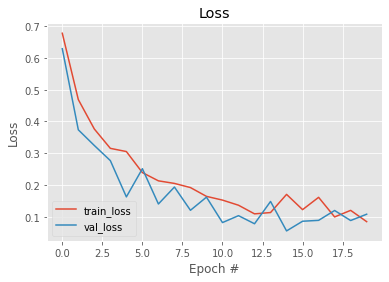

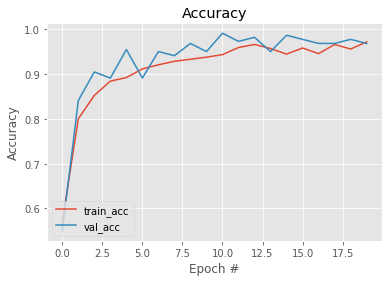

In [ ]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [ ]:
print("Evaluate")
# result = model.evaluate(image.flow(X_test,y_test,batch_size=32))
result = model.evaluate(X_test,y_test)
print(result)

Evaluate
9/9 [==============================] - 0s 17ms/step - loss: 0.0835 - accuracy: 0.9783
[0.08351922780275345, 0.97826087474823]
